In [4]:
from __future__ import annotations

import nshconfig_extra as CE
import nshtrainer as nt

import jmp.configs as jc

config = jc.Config.draft()
config.pretrained_ckpt = CE.CachedPath(uri="/mnt/shared/checkpoints/jmp-s.pt")
config.graph_computer = jc.GraphComputerConfig(
    cutoffs=jc.CutoffsConfig.from_constant(12.0),
    max_neighbors=jc.MaxNeighborsConfig.from_goc_base_proportions(30),
    pbc=True,
    per_graph_radius_graph=False,
)
config.energy_referencer = jc.IdentityReferencerConfig()
config.targets = jc.TargetsConfig.draft()
config.targets.energy = jc.EnergyTargetConfig(max_atomic_number=120)
config.targets.force = jc.ForceTargetConfig()
config.targets.stress = jc.StressTargetConfig()
config.targets.energy_loss_coefficient = 1.0
config.targets.force_loss_coefficient = 1.0
config.targets.stress_loss_coefficient = 1.0
config.optimization = jc.OptimizationConfig.draft()
config.optimization.optimizer = nt.configs.AdamWConfig(lr=2.0e-4)
config.optimization.lr_scheduler = None
config = config.finalize()
config

Config(pretrained_ckpt=CachedPath(uri='/mnt/shared/checkpoints/jmp-s.pt', cache_dir=None, extract_archive=False, force_extract=False, quiet=False), graph_computer=GraphComputerConfig(cutoffs=CutoffsConfig(main=12.0, aeaint=12.0, qint=12.0, aint=12.0), max_neighbors=MaxNeighborsConfig(main=30, aeaint=20, qint=8, aint=1000), pbc=True, per_graph_radius_graph=False), ignore_graph_generation_errors=False, targets=TargetsConfig(energy=EnergyTargetConfig(max_atomic_number=120, reduction='sum', edge_level_energies=False, num_mlps=5), force=ForceTargetConfig(reduction='sum', num_mlps=5), stress=StressTargetConfig(reduction='sum', num_layers=2), energy_loss_coefficient=1.0, force_loss_coefficient=1.0, stress_loss_coefficient=1.0), optimization=OptimizationConfig(optimizer=AdamWConfig(name='adamw', lr=0.0002, weight_decay=0.01, betas=(0.9, 0.999), eps=1e-08, amsgrad=False), lr_scheduler=None, separate_lr_multiplier=None), energy_referencer=PerAtomReferencerConfig(name='per_atom_referencer', refer

In [6]:
from jmp.lightning_module import Module

module = Module(config).cuda().eval()
module

Unrecognized arguments:  dict_keys(['ln', 'dropout', 'replace_scale_factors_with_ln', 'learnable_rbf', 'learnable_rbf_stds', 'unique_basis_per_layer', 'old_gaussian_implementation', 'edge_dropout'])


CRITICAL:root:Found the following scale factors: [('int_blocks.0.trip_interaction.scale_rbf', 'int_blocks.0.trip_interaction.scale_rbf'), ('int_blocks.0.trip_interaction.scale_cbf_sum', 'int_blocks.0.trip_interaction.scale_cbf_sum'), ('int_blocks.0.quad_interaction.scale_rbf', 'int_blocks.0.quad_interaction.scale_rbf'), ('int_blocks.0.quad_interaction.scale_cbf', 'int_blocks.0.quad_interaction.scale_cbf'), ('int_blocks.0.quad_interaction.scale_sbf_sum', 'int_blocks.0.quad_interaction.scale_sbf_sum'), ('int_blocks.0.atom_edge_interaction.scale_rbf', 'int_blocks.0.atom_edge_interaction.scale_rbf'), ('int_blocks.0.atom_edge_interaction.scale_cbf_sum', 'int_blocks.0.atom_edge_interaction.scale_cbf_sum'), ('int_blocks.0.edge_atom_interaction.scale_rbf', 'int_blocks.0.edge_atom_interaction.scale_rbf'), ('int_blocks.0.edge_atom_interaction.scale_cbf_sum', 'int_blocks.0.edge_atom_interaction.scale_cbf_sum'), ('int_blocks.0.atom_interaction.scale_rbf_sum', 'int_blocks.0.atom_interaction.scale_r

Module(hparams=Config(pretrained_ckpt=CachedPath(uri='/mnt/shared/checkpoints/jmp-s.pt', cache_dir=None, extract_archive=False, force_extract=False, quiet=False), graph_computer=GraphComputerConfig(cutoffs=CutoffsConfig(main=12.0, aeaint=12.0, qint=12.0, aint=12.0), max_neighbors=MaxNeighborsConfig(main=30, aeaint=20, qint=8, aint=1000), pbc=True, per_graph_radius_graph=False), ignore_graph_generation_errors=False, targets=TargetsConfig(energy=EnergyTargetConfig(max_atomic_number=120, reduction='sum', edge_level_energies=False, num_mlps=5), force=ForceTargetConfig(reduction='sum', num_mlps=5), stress=StressTargetConfig(reduction='sum', num_layers=2), energy_loss_coefficient=1.0, force_loss_coefficient=1.0, stress_loss_coefficient=1.0), optimization=OptimizationConfig(optimizer=AdamWConfig(name='adamw', lr=0.0002, weight_decay=0.01, betas=(0.9, 0.999), eps=1e-08, amsgrad=False), lr_scheduler=None, separate_lr_multiplier=None), energy_referencer=PerAtomReferencerConfig(name='per_atom_ref

In [52]:
import datasets

dataset = datasets.load_dataset("nimashoghi/mptrj", split="train", streaming=True)
dataset = dataset.filter(lambda extxyz_id: extxyz_id == 0, input_columns=["extxyz_id"])
dataset_iter = iter(dataset)
dataset

IterableDataset({
    features: Unknown,
    n_shards: 8
})

In [49]:
import torch
from torch_geometric.data import Batch, Data


def new_batch():
    data_dict = next(dataset_iter)
    data = Data.from_dict(
        {
            "pos": torch.tensor(data_dict["positions"], dtype=torch.float),
            "atomic_numbers": (
                atomic_numbers := torch.tensor(data_dict["numbers"], dtype=torch.long)
            ),
            "tags": torch.full_like(atomic_numbers, 2, dtype=torch.long),
            "fixed": torch.zeros_like(atomic_numbers, dtype=torch.bool),
            # "natoms": data_dict["natoms"].long(),
            "natoms": torch.tensor(data_dict["num_atoms"], dtype=torch.long),
            # "cell": data_dict["cell"].view(1, 3, 3),
            "cell": torch.tensor(data_dict["cell"], dtype=torch.float).view(1, 3, 3),
            # "y": data_dict["corrected_total_energy"],
            "energy": torch.tensor(
                data_dict["corrected_total_energy"], dtype=torch.float
            ),
            # "force": data_dict["forces"],
            "force": torch.tensor(data_dict["forces"], dtype=torch.float),
            # "stress": data_dict["stress"].view(1, 3, 3),
            "stress": torch.tensor(data_dict["stress"], dtype=torch.float).view(
                1, 3, 3
            ),
            # "eform": data_dict["ef_per_atom_relaxed"],
            "eform": torch.tensor(data_dict["ef_per_atom_relaxed"], dtype=torch.float),
        }
    )
    batch = Batch.from_data_list([data])
    return batch


In [56]:
from lightning.fabric.utilities.apply_func import move_data_to_device
from tqdm import trange

num_embeddings = 10_000

torch.no_grad().__enter__()

embeddings = []
eforms = []

for i in trange(num_embeddings):
    batch = new_batch()
    embedding = module.embeddings(batch)
    eform = batch.eform

    embedding = move_data_to_device(embedding, "cpu")
    eform = move_data_to_device(eform, "cpu")

    embeddings.append(embedding)
    eforms.append(eform)


  0%|          | 0/1827 [00:00<?, ?it/s]

100%|██████████| 1827/1827 [01:07<00:00, 26.88it/s]


In [58]:
import numpy as np

embeddings_avg = torch.stack(
    [embedding["energy"].mean(dim=0) for embedding in embeddings]
).numpy()
labels = torch.stack(eforms).numpy()

print(embeddings_avg.shape, labels.shape)

# Save to /mnt/shared/jmp-wbm-embeddings/wbm/

np.save("/mnt/shared/jmp-wbm-embeddings/mptrj/embeddings_avg.npy", embeddings_avg)
np.save("/mnt/shared/jmp-wbm-embeddings/mptrj/labels.npy", labels)


(10000, 256) (10000, 1)


OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

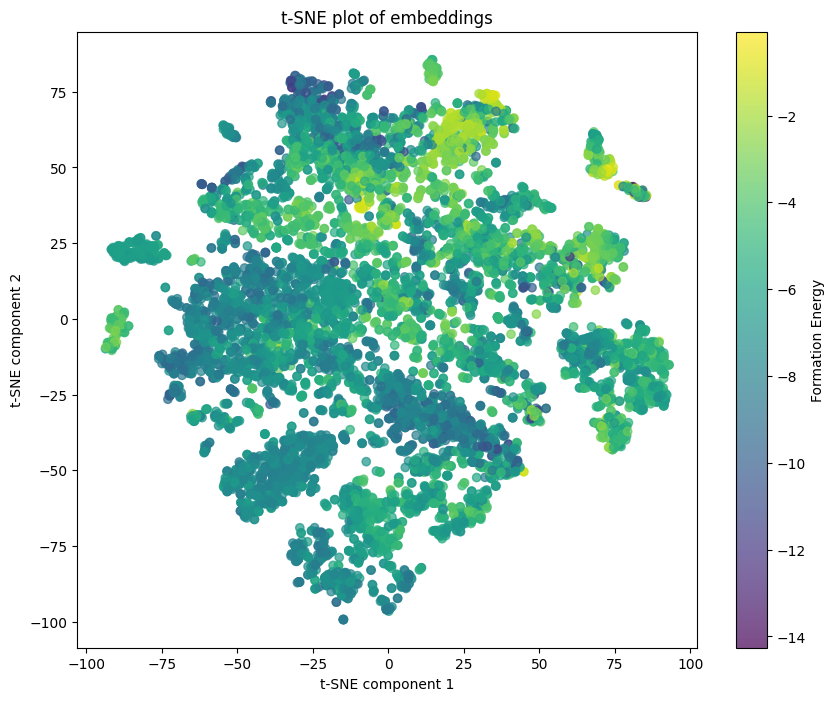

In [59]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Perform t-SNE on the embeddings
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings_avg)

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=labels, cmap="viridis", alpha=0.7
)
plt.colorbar(scatter, label="Formation Energy")
plt.title("t-SNE plot of embeddings")
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.show()